# "K-histograms" for catergorizing keyframes from a camera feed by unique scene
-----

Problem:  Categorizing frames from surveilance footage by unique "scene" (tilt, pan, zoom etc.).

Solution:  Clustering by comparing histograms of greyscale pixels from fixed-sized patches in a fixed-sized region-of-interest (ROI) from the camera, across all frames.

Example:  You have a surveilance camera that alternates between three different scenes on a fixed schedule and you do not know 'ex ante' to which scene a frame belongs.

Routine:
1. User selects size of fixed tiles according to imagery features.
2. User selects a ROI in the scene.
3. User selects a threshold to compare bilevel histograms.
4. User defines number of unique scenes from empirical evidence.
5. Program will crop scene to ROI and desaturate image according to the ITU-R 601-2 luma transform.
6. Program will "equalize histogram" of greyscale intensity values across entire ROI.
7. Program will calculate bilevel histograms for all tiles in the ROI for the frame according to user-defined threshold.
8. Program will flatten all histograms in a frame sequentially, ensuring that spatial information about the image is preserved during clustering.
9. Program will attempt to cluster the frames into the number of scenes defined by the user, using the Euclidean distance metric to evaluate similarity of the flattened spatial histograms across all frames.
10. Program will return labels of all the frames.

Analysis:  Allows the user to view plots of clustering behavior, as well as to identify the frames that are most-difficult to categorize.

## User Settings for Frames, Scenes, Tiles and Histograms

In [1]:
from __future__ import print_function
from __future__ import division

import os
import time
import sys

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


# LOCATION OF FRAMES TO CLUSTER
frame_dir = "frames"
files = [os.path.join(frame_dir,d) for d in sorted(os.listdir(frame_dir)) if not d.startswith('.')]  
num_frames = len(files)

# FRAME and SCENE INFORMATION
frame_height = 720
frame_width = 1280
pixel_depth = 255  # Number of levels per pixel.
num_scenes = 3

# REGION OF INTEREST (ROI) INFORMATION
tile_width = 80  # desired width of a tile.
tile_height = 80  # desired height of a tile.

tiles_per_row = int(frame_width/tile_width) # 16
tiles_per_column = int(frame_height/tile_height) # 9
tiles_per_frame = tiles_per_row * tiles_per_column # 144

# INDEXING FROM ZERO IN THE TOP LEFT CORNER, 
# FROM LEFT TO RIGHT, AND TOP TO BOTTOM,
# INDICATE A LIST OF TILES THAT CONSTITUE THE ROI:
roi_tiles = range(32,80) # corresponds to 3rd, 4th, and 5th rows
num_roi_tiles = len(roi_tiles) # 48

# HISTOGRAM SETTINGS
num_bins = 2 # 2 for bilevel comparison
threshold = 15 # roughly corresponds to isloating the darkest 10% of pixels

## Proprietary Functions

In [2]:
def image_histogram_equalization(image, number_bins=256):
  # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html
  # https://en.wikipedia.org/wiki/Histogram_equalization
  # image is a numpy array
    
  # get image histogram
  image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
  cdf = image_histogram.cumsum() # cumulative distribution function
  cdf = 255 * cdf / cdf[-1] # normalize

  # use linear interpolation of cdf to find new pixel values
  image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
  #image_equalized = image_equalized.astype(int)

  return image_equalized.reshape(image.shape), cdf


def status_update(frame_number,tot_frames):
  percent = frame_number * 100 / tot_frames

  if k % 10 == 0:
      sys.stdout.write("%.0f%%" % percent)
      sys.stdout.flush()
  else:
      sys.stdout.write(".")
      sys.stdout.flush()

## Generating Histograms routine

In [3]:
# INITIALIZE INPUT DATA ARRAY FOR CLUSTERING OPERATION
# INITIALIZE LABEL ARRAY
X = np.empty((num_frames, (num_roi_tiles * num_bins)))
y = np.empty(num_frames, dtype=int)
k = 0
start = time.time()
print ("Histogramming frames...")


# the following loops through all frames in a directory
for keyframe in files:
  # READ IN IMAGE TO NUMPY ARRAY AND CONVERT TO B&W
  input_frame = keyframe  
  img = Image.open(input_frame).convert("L")
  img = np.array(img, dtype="uint8")
    
  # CROP IMAGE TO ROI
  img = img[0:(tile_height)*5,:]

  # "EQUALIZE HISTOGRAM" ACROSS ENTIRE ROI
  img, _ = image_histogram_equalization(img, number_bins = 256)

  # Initialize numpy array to hold global flattened histogram values for frame
  flat_hist = np.zeros(num_roi_tiles * num_bins) # 96

  # initialize some counters
  tile_index = 0  
  l = 0  

  # the following loops through every tile in the ROI
  for i in range(tiles_per_column): #for every row top to bottom  
    for j in range(tiles_per_row): #for every column left to right
      if tile_index in roi_tiles:
        # crop a tile from the ROI
        tile = img[i*tile_height:(i+1)*tile_height,j*tile_width:(j+1)*tile_width]
        
        # make a flattened bilevel histogram according to user-defined threshold
        tile_histogram = np.histogram(tile, bins=[0, threshold, 256], range = (0,256), density = False) #auto flattens
        
        # normalize the histogram and add it to the global flattened histograms vector for the frame
        flat_hist[l*num_bins:(l+1)*num_bins] = tile_histogram[0]/tile_histogram[0].sum()
        
        # increment counters
        tile_index += 1
        l += 1
      else:
        tile_index += 1

  # add flattened global histogram to data
  X[k] = flat_hist 

  # STATUS UPDATE
  status_update(frame_number = k,tot_frames = num_frames)
    
  k += 1

end = time.time()

print ()
print ("Histogram-ization for all frames: %.2f seconds" %(end - start))
print("Histogram-ization completed.")

Histogramming frames...
0%.........6%.........12%.........19%.........25%.........31%.........38%.........44%.........50%.........56%.........62%.........69%.........75%.........81%.........88%.........94%.........
Histogram-ization for all frames: 11.85 seconds
Histogram-ization completed.


## Clustering Operation

In [4]:
# INITIALIZE CLUSTERING FROM SKLEARN LIBRARY
kmeans = KMeans(n_clusters = num_scenes, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                tol=0.0001).fit(X,y)

# STORE PREDECTIONS TO ARRAY
y_hat = kmeans.labels_

# STORE DISTANCES TO ARRAY
distances = KMeans.transform(kmeans,X)

# PRINT OUTPUT
print("Clustering completed.  Scene counts: ",np.bincount(y_hat))
print("Distance to cluster centers available as \"distances\".")
print("Predicted labels available as \"y_hat\".")
print("Cluster score on frame directory: ",kmeans.score(X))
#print(y_hat)

Clustering completed.  Scene counts:  [75 33 52]
Distance to cluster centers available as "distances".
Predicted labels available as "y_hat".
Cluster score on frame directory:  -69.2897421956


## EVALUATING CLUSTERS

Analysis to explore the clustering behavior of the camera feed.

### PCA-reduced 2D plots of Cluster Op

The following reduces multi-variate histograms into two-dimensional vectors for easy visualization of clustering behavior.

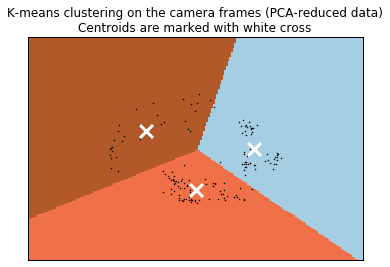

In [5]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++',
                n_clusters = num_scenes,
                n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the camera frames (PCA-reduced data)\n'
          'Centroids are marked with white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Identification of frames nearest the decision boundaries

The following uses an implementation of the closest-pair problem to identify frames that are closest to the decision boundaries.  From an intuitive standpoint, these frames are the "most-difficult" to categorize.

In [6]:
# NUMBER OF FRAMES TO IDENTIFY
num_difficult_frames = 10

# SORT
sort_dist = np.sort(distances, axis=-1, kind='quicksort', order=None)

# CALCULATE DISTANCES TO CLUSTER CENTERS
cluster_dist = np.empty((num_frames, num_scenes - 1 ))
min_dist = np.empty ((num_frames, 1))

for i in range(num_frames):
    for j in range(num_scenes - 1) :
        cluster_dist[i,j] = sort_dist[i,j+1]-sort_dist[i,j]
    min_dist[i] = min(cluster_dist[i])

# RETURN INDEX OF MOST-DIFFICULT FRAMES
difficult_frames = sorted(range(len(min_dist)), key=lambda k: min_dist[k])[0:num_difficult_frames] #narrowest to largest distance
print("Difficult frames: ", difficult_frames)

Difficult frames:  [68, 69, 23, 61, 74, 83, 32, 87, 104, 3]


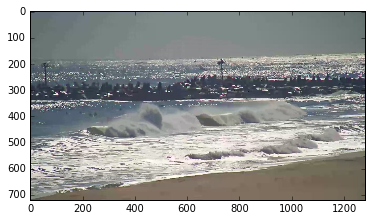

In [7]:
# VIEW DIFFICULT FRAMES
most_difficult = difficult_frames[0]
img = Image.open(files[most_difficult])
imgplot = plt.imshow(img)
plt.show()